In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
import glob
from PIL import Image
import glob
all_images=[]
all_labels=[]
img_size=(96,96)
for f in glob.glob('..\\data\\foods\\**\\*.jpg', recursive=True):
    arr=f.split('\\')
    img = Image.open(f)
    img_resize = img.resize((img_size[0], img_size[1]))
    all_images.append(img_resize)
    label=0
    if arr[3]=='Chicken':
        label=0
    elif arr[3]=='Dolsot':
        label=1
    elif arr[3]=='Jeyug':
        label=2
    elif arr[3]=='Kimchi':
        label=3
    elif arr[3]=='Samgyeob':
        label=4
    elif arr[3]=='Soybean':
        label=5
    all_labels.append(label)

In [12]:
import numpy as np
X = np.empty((1, img_size[0], img_size[1], 3)) # np.empty(row, width, height, channel)
for img in all_images:
    X = np.vstack((X, np.array(img).reshape(1, img_size[0], img_size[1], 3))) # vstack : 새로로 누적
X.shape

(179, 96, 96, 3)

In [13]:
X = np.delete(X, (0), axis=0) # 첫번째 빈 이미지 삭제

In [14]:
X.shape

(178, 96, 96, 3)

In [15]:
y = np.array(all_labels)
y[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

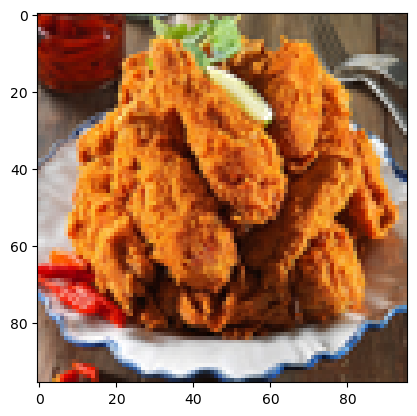

In [16]:
import matplotlib.pyplot as plt
plt.imshow(all_images[0])
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142, 96, 96, 3), (36, 96, 96, 3), (142,), (36,))

In [18]:
import pandas as pd
pd.DataFrame(y_train).value_counts()

0    24
1    24
3    24
4    24
5    24
2    22
dtype: int64

In [20]:
X_train = X_train.reshape(-1,img_size[0]*img_size[1]*3)
X_test = X_test.reshape(-1,img_size[0]*img_size[1]*3)

In [21]:
X_train = X_train / 255.
X_test = X_test / 255.

In [22]:
X_train = X_train.reshape(-1, img_size[0], img_size[1], 3)
X_test = X_test.reshape(-1, img_size[0], img_size[1], 3)

In [23]:
y_train[:10]

array([3, 5, 5, 5, 2, 0, 5, 2, 1, 2])

In [24]:
from tensorflow.keras import utils
y_train_backup=y_train
y_test_backup=y_test
y_train=utils.to_categorical(y_train,6)
y_test=utils.to_categorical(y_test,6)

In [25]:
y_train[:5]

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense,Flatten
model=Sequential()
model.add(Conv2D(64,(3,3),padding="same", input_shape=X_train.shape[1:],activation='tanh'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3),activation="tanh"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(16,(3,3),activation="tanh"))
model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(6,activation="softmax"))
model.compile(optimizer="rmsprop", loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 16)        4624      
                                                                 
 flatten (Flatten)           (None, 7056)              0

In [27]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("../models/food_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
hist = model.fit(X_train, y_train, batch_size=32, validation_split=0.2, epochs=100, callbacks=[checkpoint])

Epoch 1/100
4/4 [==============================] - ETA: 0s - loss: 2.3907 - accuracy: 0.1681
Epoch 1: val_accuracy improved from -inf to 0.03448, saving model to ../models\food_best.h5
4/4 [==============================] - 7s 215ms/step - loss: 2.3907 - accuracy: 0.1681 - val_loss: 4.1983 - val_accuracy: 0.0345
Epoch 2/100
3/4 [=====================>........] - ETA: 0s - loss: 2.6268 - accuracy: 0.1979
Epoch 2: val_accuracy improved from 0.03448 to 0.17241, saving model to ../models\food_best.h5
4/4 [==============================] - 0s 62ms/step - loss: 2.5959 - accuracy: 0.1947 - val_loss: 1.8319 - val_accuracy: 0.1724
Epoch 3/100
3/4 [=====================>........] - ETA: 0s - loss: 1.7715 - accuracy: 0.2604
Epoch 3: val_accuracy improved from 0.17241 to 0.37931, saving model to ../models\food_best.h5
4/4 [==============================] - 0s 66ms/step - loss: 1.7595 - accuracy: 0.2655 - val_loss: 1.9132 - val_accuracy: 0.3793
Epoch 4/100
3/4 [=====================>........] - ETA

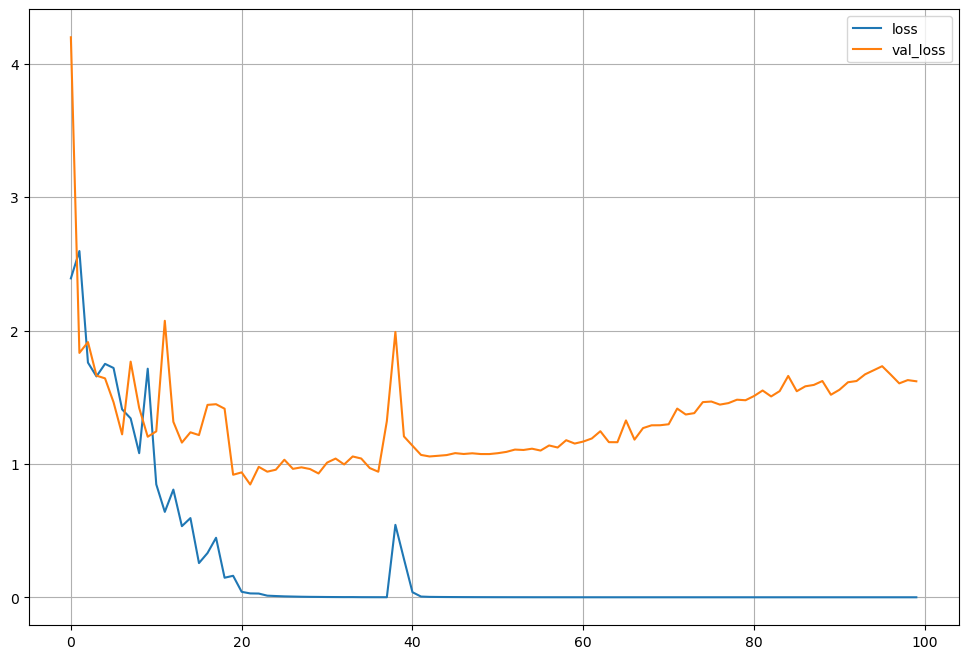

In [28]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.grid()
plt.show()

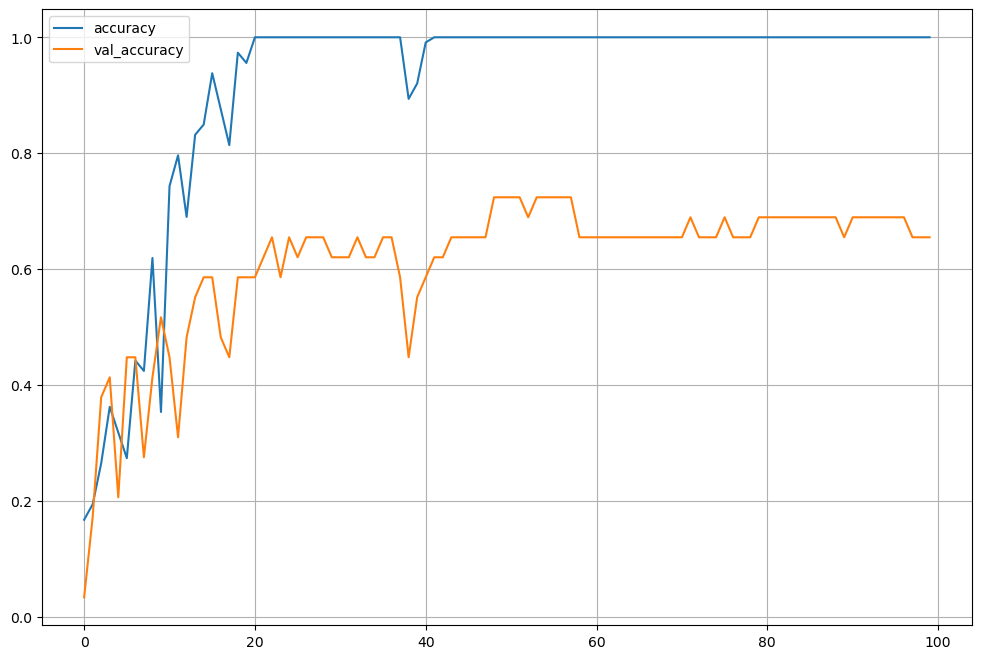

In [29]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.grid()
plt.show()

In [31]:
from tensorflow.keras.models import load_model
model = load_model('../models/food_best.h5')
scores = model.evaluate(X_train, y_train, verbose=1)
print(scores)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100)) # 학습용

5/5 [==============================] - 0s 48ms/step - loss: 0.2199 - accuracy: 0.9437
[0.21986980736255646, 0.9436619877815247]
accuracy: 94.37%


In [32]:
scores = model.evaluate(X_test, y_test, verbose=1)
print(scores)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100)) # 검증용

2/2 [==============================] - 0s 172ms/step - loss: 2.4889 - accuracy: 0.5000
[2.488874673843384, 0.5]
accuracy: 50.00%


In [33]:
pred=model.predict(X_test)
np.argmax(pred,axis=1)

2/2 [==============================] - 0s 10ms/step


array([2, 2, 5, 0, 2, 4, 4, 3, 3, 5, 1, 4, 1, 1, 2, 1, 5, 4, 1, 5, 4, 4,
       5, 2, 4, 4, 2, 0, 2, 4, 0, 5, 0, 2, 0, 2], dtype=int64)

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test_backup, np.argmax(pred,axis=1)))

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.40      0.33      0.36         6
           2       0.33      0.50      0.40         6
           3       0.50      0.17      0.25         6
           4       0.67      1.00      0.80         6
           5       0.33      0.33      0.33         6

    accuracy                           0.50        36
   macro avg       0.51      0.50      0.48        36
weighted avg       0.51      0.50      0.48        36

